### composite analysis for thermodynamic variabilities

In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [2]:
warnings.filterwarnings('ignore')

In [3]:
ISCCP_dir = '/w2-data2/willytsai/ISCCP/hgg/'
TRMM_dir = '/w2-data2/willytsai/TRMM_3hr/TRMM/'
MERRA2_dir = '/w2-data2/willytsai/MERRA2/'
MERRA2_3d_dir = '/w2-data/willytsai/'
ERA5_dir = '/w2-data/willytsai/ERA5/'
Gridsat_dir = '/w2-data2/willytsai/gridsat_BT/remap_0.25deg/'

In [4]:
%%time
# MERRA2 dataset 2014-2015, hourly in a single file
os.chdir(MERRA2_dir+'inst_2d_hourly/')
files = sorted(glob('MERRA2_400.inst1_2d_asm_Nx.2014*'))
              # + glob(MERRA2_dir+'MERRA2_400.inst1_2d_asm_Nx.2015*'))
data = xr.open_mfdataset(files)
data = data.resample(time='3H').nearest() # CWV
cwv_xr = data.TQV

CPU times: user 6.72 s, sys: 740 ms, total: 7.46 s
Wall time: 9.28 s


In [5]:
%%time 
os.chdir(ERA5_dir)
files = sorted(glob('*.nc'))
data = xr.open_mfdataset(files)
cwv_era_xr = data.tcwv

CPU times: user 19 ms, sys: 4 ms, total: 23 ms
Wall time: 24.2 ms


In [6]:
date = []; date_begin = datetime(2014,1,1)
for t in range(cwv_xr.shape[0]):
    tmp = date_begin + t*timedelta(hours=3)
    date.append(tmp)

In [7]:
%%time
# TRMM3B42 dataset 2014, 3hrly separate
yr = ['2014']
prec_3hr = np.nan*np.zeros((len(date),241,1440))

n=1
for y in yr:
    os.chdir(TRMM_dir+y)
    files = sorted(glob('3B42.*'))
    for file in files:
        data = xr.open_dataset(file).precipitation        
        prec_3hr[n-1,:,:] = data.values.swapaxes(0,1)
        n+=1
lon = data.nlon; lat = data.nlat
prec_xr = xr.DataArray(prec_3hr,coords=[date,lat,lon],dims=['time','lat','lon']); del prec_3hr

CPU times: user 52.6 s, sys: 12.6 s, total: 1min 5s
Wall time: 1min 15s


In [8]:
%%time
# MERRA2 reanalysis 2014, 3hrly 

os.chdir(MERRA2_3d_dir+'2014_TQUV_3hr/')
files = sorted(glob('MERRA2_400.inst3*'))
              # + glob(MERRA2_dir+'MERRA2_400.inst1_2d_asm_Nx.2015*'))
data = xr.open_mfdataset(files)
T_xr = data.T   
q_xr = data.QV  
u_xr = data.U
v_xr = data.V

os.chdir(MERRA2_3d_dir+'2014_omega_3hr/')
files = sorted(glob('MERRA2_400.inst3*'))
              # + glob(MERRA2_dir+'MERRA2_400.inst1_2d_asm_Nx.2015*'))
data = xr.open_mfdataset(files)
Omega_xr = data.OMEGA

CPU times: user 12.1 s, sys: 1.85 s, total: 14 s
Wall time: 17.6 s


In [9]:
%%time
# MERRA2 OLR dataset 2014-2015, hourly in a single file
os.chdir(MERRA2_dir+'inst2d_OLR')
files = sorted(glob('MERRA2_400.tavg1_2d_rad_Nx.2014*'))
              # + glob(MERRA2_dir+'MERRA2_400.inst1_2d_asm_Nx.2015*'))
data = xr.open_mfdataset(files)
data = data.resample(time='3H').nearest() # CWV
olr_xr = data.LWTUP

CPU times: user 3.54 s, sys: 187 ms, total: 3.72 s
Wall time: 4.05 s


In [10]:
%%time
# Gridsat-BT dataset 2014, 3hourly
yr = ['2014']
bt_3hr = np.nan*np.zeros((len(date),241,1440))

n=1
for y in yr:
    os.chdir(Gridsat_dir+y)
    files = sorted(glob('GRIDSAT-B1.*'))
    for file in files:
        data = xr.open_dataset(file)
        bt_3hr[n-1,:,:] = data.irwin_cdr
        n+=1
lon = data.lon; lat = data.lat
bt_xr = xr.DataArray(bt_3hr,coords=[date,lat,lon],dims=['time','lat','lon']); del bt_3hr

CPU times: user 10min 9s, sys: 7.78 s, total: 10min 17s
Wall time: 1min 24s


In [11]:
# derive Relative hunidity
lev = T_xr.lev
es = 6.1094*np.exp(17.625*(T_xr-273)/(T_xr-273+243.04))
p = (q_xr/q_xr)*lev
qs = es/(p-es)*0.622
rh_xr = q_xr/qs*100 # relative humidity [%] 

In [12]:
%%time
cldamt_type_3hr = np.nan*np.zeros((len(date),18,180,360))
cldamt_3hr = np.nan*np.zeros((len(date),180,360))
# ISCCP dataset 2014, 3hourly in a single file
yr = ['2014'] # year
mn = ['01','02','03','04','05','06','07','08',
     '09','10','11','12'] # month

n=1
for y in yr:
    for m in mn:
        os.chdir(ISCCP_dir+y+m)
        files = sorted(glob('*.nc'))
        
        for file in files:
            data = xr.open_dataset(file).cldamt_types # cloud amount [%]
            data2 = xr.open_dataset(file).cldamt
            tmp = data; tmp2 = data2
            cldamt_type_3hr[n-1,:,:,:] = tmp
            cldamt_3hr[n-1,:,:] = tmp2
            n+=1
lat = tmp.lat; lon = tmp.lon
print(n-1)
cldamt_type_xr = xr.DataArray(cldamt_type_3hr,coords=[date,range(18),lat,lon],dims=['time','type','lat','lon']); del cldamt_type_3hr
cldamt_xr = xr.DataArray(cldamt_3hr,coords=[date,lat,lon],dims=['time','lat','lon']); del cldamt_3hr

2920
CPU times: user 56min 20s, sys: 5min 28s, total: 1h 1min 48s
Wall time: 8min 44s


In [13]:
lat = cldamt_type_xr.lat
lon = cldamt_type_xr.lon
# 0+3 shallow cumulus, 2+5 stratoform, 14+17 deep convection 
cldamt_cu = (cldamt_type_xr[:,0,:,:]+cldamt_type_xr[:,3,:,:]).values
cldamt_cu[cldamt_cu>100] = np.nan; cldamt_cu[cldamt_cu< 0] = np.nan;
cu_xr = xr.DataArray(cldamt_cu,coords=[date,lat,lon],dims=['time','lat','lon']); del cldamt_cu

cldamt_st = (cldamt_type_xr[:,13,:,:]+cldamt_type_xr[:,16,:,:]).values
cldamt_st[cldamt_st>100] = np.nan; cldamt_st[cldamt_st< 0] = np.nan;
st_xr = xr.DataArray(cldamt_st,coords=[date,lat,lon],dims=['time','lat','lon']); del cldamt_st

cldamt_dc = (cldamt_type_xr[:,14,:,:]+cldamt_type_xr[:,17,:,:]).values
cldamt_dc[cldamt_dc>100] = np.nan; cldamt_dc[cldamt_dc< 0] = np.nan;
dc_xr = xr.DataArray(cldamt_dc,coords=[date,lat,lon],dims=['time','lat','lon']); del cldamt_dc

#### Composite time series for thermodynamic variability based on degree of organization

In [248]:
start_date = datetime(2014,1,1)
end_date = datetime(2015,1,1)

# INDO = lat(-5,5), lon(65,75)
lat_s,lat_n = -5,5
lon_w,lon_e = 65,75 

In [249]:
prec_sm = prec_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
cwv_sm = cwv_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
cwv_era_sm = cwv_era_xr.sel(latitude=slice(lat_s,lat_n),longitude=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
dc_sm = dc_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
cu_sm = cu_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
st_sm = st_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
cldamt_sm = cldamt_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))

T_sm = T_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
q_sm = q_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
u_sm = u_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
v_sm = v_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
omega_sm = Omega_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
rh_sm = rh_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
olr_sm = olr_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
bt_sm = bt_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))

# derive low level wind shear (LLWS)
llwsz_sm = np.abs(u_sm[:,6,:,:]-u_sm[:,1,:,:]) # |Usfc-U850|

In [250]:
### number of precipitating systems 
os.chdir('/w2-data2/willytsai/python_module')
import SCAI_calc4obj as scai

In [251]:
N_ps = np.zeros(prec_sm.shape[0]) # OLR_based
N_psT = np.zeros(prec_sm.shape[0]) # BT_based
N_prec = np.zeros(prec_sm.shape[0]) # prec_based
cldfrac = np.zeros(prec_sm.shape[0]) # cldfrac over domain by OLR criteria
precfrac = np.zeros(prec_sm.shape[0]) # cldfrac over domain by OLR criteria

for t in range(prec_sm.shape[0]):
    label_obj, N = scai.labeled_obj(olr_sm[t,:,:].values,cri=220,flag=2) # less than 220 W/m^2
    N_ps[t] = N

for t in range(prec_sm.shape[0]):
    label_obj, N = scai.labeled_obj(bt_sm[t,:,:].values,cri=240,flag=2) # less than 220 W/m^2
    N_psT[t] = N
    
for t in range(prec_sm.shape[0]):
    label_obj, N = scai.labeled_obj(prec_sm[t,:,:].values,cri=1,flag=1) # larger than 1mm/day
    N_prec[t] = N

N_ps = xr.DataArray(N_ps,coords=[date],dims=['time'])
N_psT = xr.DataArray(N_psT,coords=[date],dims=['time'])
N_prec = xr.DataArray(N_prec,coords=[date],dims=['time'])

In [252]:
# cloud fraction (by OLR < 180)
for t in range(prec_sm.shape[0]):
    tmp = len(np.where(olr_sm[t,:,:].values.ravel()<220)[0])/len(olr_sm[t,:,:].values.ravel())
    cldfrac[t] = tmp
    
# prec fraction (by prec > 1mm/hr)
for t in range(prec_sm.shape[0]):
    tmp = len(np.where(prec_sm[t,:,:].values.ravel()>1)[0])/len(prec_sm[t,:,:].values.ravel())
    precfrac[t] = tmp
precfrac = xr.DataArray(precfrac,coords=[date],dims=['time'])

In [253]:
# 3-point smooth 
N = 2 # 6hrly running mean
N_ps_rm = np.convolve(N_ps, np.ones((N,))/N)[(N-1):]
N_psT_rm = np.convolve(N_psT, np.ones((N,))/N)[(N-1):]
N_prec_rm = np.convolve(N_prec, np.ones((N,))/N)[(N-1):]

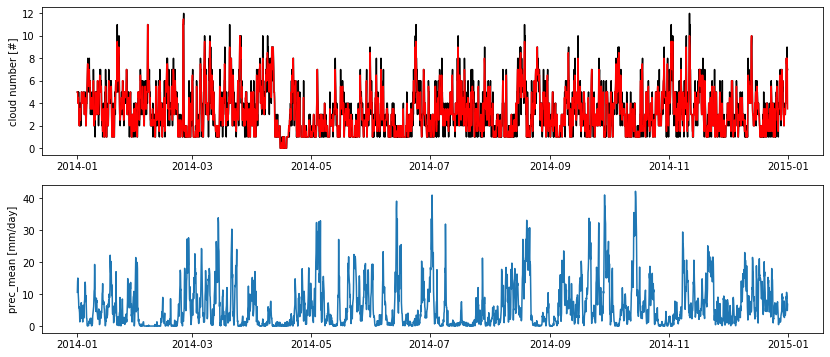

In [254]:
fig = plt.figure(figsize=(14,6))

ax1 = plt.subplot(2,1,1)
ax1.plot(prec_sm.time,N_ps,'k')
ax1.plot(prec_sm.time,N_ps_rm,'r')
#ax1.plot(prec_sm.time,N_prec_rm,'b')
ax1.set_ylabel('cloud number [#]')

ax2 = plt.subplot(2,1,2)
ax2.plot(prec_sm.time,(prec_sm.mean(axis=1)).mean(axis=1)*24)
ax2.set_ylabel('prec_mean [mm/day]')
plt.show()

Text(0, 0.5, 'cloud fraction')

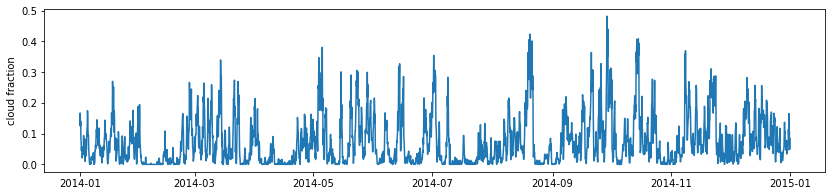

In [255]:
fig = plt.figure(figsize=(14,3))
plt.plot(prec_sm.time,precfrac)
plt.ylabel('cloud fraction')

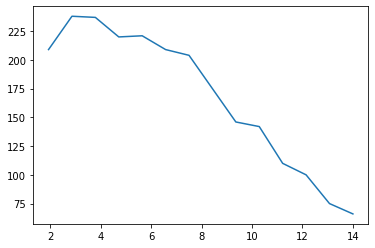

In [256]:
num, bins = np.histogram(N_prec,bins=14,range=(1,14))
plt.plot(bins[1:],num)

0.2975
7.0
0.042499999999999996
52.789198722504075


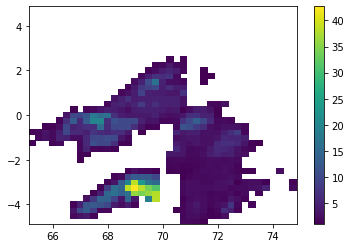

In [257]:
bb = datetime(2014,6,14)

test = prec_sm.sel(time=bb).values.copy()
test[test<1] = np.nan

plt.pcolor(prec_sm.lon,prec_sm.lat,test)
plt.colorbar()
print(precfrac.sel(time=bb).values)
print(N_prec.sel(time=bb).values)
print((precfrac.sel(time=bb)/N_prec.sel(time=bb)).values)
print(prec_dmean.sel(time=bb).values)

In [258]:
prec_dmean = (prec_sm.mean(axis=1)).mean(axis=1)*24 # domain averaged mm/day

t_scat = np.where(np.logical_and(np.logical_and(prec_dmean>5,N_prec < 4)
                               ,precfrac>0))[0] # org
t_org = np.where(np.logical_and(np.logical_and(prec_dmean>5,N_prec > 8)
                               ,precfrac>0))[0] # scattered
print(len(t_scat),len(t_org))

127 641


In [259]:
# 3-day before and after for the time window 
qverta_org = np.zeros((len(t_org),49,len(lev)))
qverta_scat = np.zeros((len(t_scat),49,len(lev)))
Tverta_org = np.zeros((len(t_org),49,len(lev)))
Tverta_scat = np.zeros((len(t_scat),49,len(lev)))

prec_org = np.zeros((len(t_org),49))
prec_scat = np.zeros((len(t_scat),49))

N_org = np.copy(prec_org)
N_scat = np.copy(prec_scat)

cwv_org = np.copy(prec_org)
cwv_scat = np.copy(prec_scat)

dcamt_org = np.copy(prec_org)
dcamt_scat = np.copy(prec_scat)
cuamt_org = np.copy(prec_org)
cuamt_scat = np.copy(prec_scat)
stamt_org = np.copy(prec_org)
stamt_scat = np.copy(prec_scat)

for i,t in enumerate(t_org):
    
    tmp = np.nanmean(np.nanmean(q_sm[t-24:t+25,:,:,:],axis=2),axis=2)
    tmp2 = np.nanmean(np.nanmean(T_sm[t-24:t+25,:,:,:],axis=2),axis=2)
    tmp3 = N_prec[t-24:t+25]
    tmp4 = np.nanmean(np.nanmean(prec_sm[t-24:t+25,:,:],axis=1),axis=1)
    tmp5 = np.nanmean(np.nanmean(cwv_sm[t-24:t+25,:,:],axis=1),axis=1)
    tmp6 = np.nanmean(np.nanmean(dc_sm[t-24:t+25,:,:],axis=1),axis=1)
    tmp7 = np.nanmean(np.nanmean(cu_sm[t-24:t+25,:,:],axis=1),axis=1)
    tmp8 = np.nanmean(np.nanmean(st_sm[t-24:t+25,:,:],axis=1),axis=1)

    try:
        qverta_org[i,:,:] = tmp - np.nanmean(tmp,axis=0)
        Tverta_org[i,:,:] = tmp2 - np.nanmean(tmp2,axis=0)
        N_org[i,:] = tmp3 
        prec_org[i,:] = tmp4
        cwv_org[i,:] = tmp5
        dcamt_org[i,:] = tmp6
        cuamt_org[i,:] = tmp7
        stamt_org[i,:] = tmp8
        
    except:
        qverta_org[i,:,:] = np.nan
        Tverta_org[i,:,:] = np.nan
        N_org[i,:] = np.nan 
        prec_org[i,:] = np.nan
        cwv_org[i,:] = np.nan
        dcamt_org[i,:] = np.nan
        cuamt_org[i,:] = np.nan
        stamt_org[i,:] = np.nan
        
for i,t in enumerate(t_scat):
    
    tmp = np.nanmean(np.nanmean(q_sm[t-24:t+25,:,:,:],axis=2),axis=2)
    tmp2 = np.nanmean(np.nanmean(T_sm[t-24:t+25,:,:,:],axis=2),axis=2)
    tmp3 = N_prec[t-24:t+25]
    tmp4 = np.nanmean(np.nanmean(prec_sm[t-24:t+25,:,:],axis=1),axis=1)
    tmp5 = np.nanmean(np.nanmean(cwv_sm[t-24:t+25,:,:],axis=1),axis=1)
    tmp6 = np.nanmean(np.nanmean(dc_sm[t-24:t+25,:,:],axis=1),axis=1)
    tmp7 = np.nanmean(np.nanmean(cu_sm[t-24:t+25,:,:],axis=1),axis=1)
    tmp8 = np.nanmean(np.nanmean(st_sm[t-24:t+25,:,:],axis=1),axis=1)
    
    try:
        qverta_scat[i,:,:] = tmp - np.nanmean(tmp,axis=0)
        Tverta_scat[i,:,:] = tmp2 - np.nanmean(tmp2,axis=0)
        N_scat[i,:] = tmp3 
        prec_scat[i,:] = tmp4
        cwv_scat[i,:] = tmp5
        dcamt_scat[i,:] = tmp6
        cuamt_scat[i,:] = tmp7
        stamt_scat[i,:] = tmp8
        
    except:
        qverta_scat[i,:,:] = np.nan
        Tverta_scat[i,:,:] = np.nan
        N_scat[i,:] = np.nan 
        prec_scat[i,:] = np.nan
        cwv_scat[i,:] = np.nan
        dcamt_scat[i,:] = np.nan
        cuamt_scat[i,:] = np.nan
        stamt_scat[i,:] = np.nan

In [260]:
cwvenv_org = np.copy(prec_org)
cwvenv_scat = np.copy(prec_scat)
llwsz_org = np.copy(prec_org)
llwsz_scat = np.copy(prec_scat)

for i,t in enumerate(t_org):
    try:
        tmp = np.nanmean(np.nanmean(cwvenv[t-24:t+25,:,:],axis=1),axis=1)
        tmp2 = np.nanmean(np.nanmean(llwsz_sm[t-24:t+25,:,:],axis=1),axis=1)
        cwvenv_org[i,:] = tmp
        llwsz_org[i,:] = tmp2
    except:
        cwvenv_org[i,:] = np.nan
        llwsz_org[i,:] = np.nan
        
for i,t in enumerate(t_scat):
    try:
        tmp = np.nanmean(np.nanmean(cwvenv[t-24:t+25,:,:],axis=1),axis=1)
        tmp2 = np.nanmean(np.nanmean(llwsz_sm[t-24:t+25,:,:],axis=1),axis=1)
        cwvenv_scat[i,:] = tmp
        llwsz_scat[i,:] = tmp2
    except:
        cwvenv_scat[i,:] = np.nan
        llwsz_scat[i,:] = np.nan

In [261]:
qverta_orgmean = np.nanmean(qverta_org,axis=0)
qverta_scatmean = np.nanmean(qverta_scat,axis=0)

Tverta_orgmean = np.nanmean(Tverta_org,axis=0)
Tverta_scatmean = np.nanmean(Tverta_scat,axis=0)

llwsz_orgmean = np.nanmean(llwsz_org,axis=0)
llwsz_scatmean = np.nanmean(llwsz_scat,axis=0)

N_orgmean = np.nanmean(N_org,axis=0)
N_scatmean = np.nanmean(N_scat,axis=0)
N_orgstder = np.nanstd(N_org,axis=0)/len(t_org)
N_scatstder = np.nanstd(N_scat,axis=0)/len(t_scat)

prec_orgmean = np.nanmean(prec_org,axis=0)
prec_scatmean = np.nanmean(prec_scat,axis=0)
prec_orgstder = np.nanstd(prec_org,axis=0)
prec_scatstder = np.nanstd(prec_scat,axis=0)

cwv_orgmean = np.nanmean(cwv_org,axis=0)
cwv_scatmean = np.nanmean(cwv_scat,axis=0)
cwv_orgstder = np.nanstd(cwv_org,axis=0)
cwv_scatstder = np.nanstd(cwv_scat,axis=0)
# cwv_env
cwvenv_orgmean = np.nanmean(cwvenv_org,axis=0)
cwvenv_scatmean = np.nanmean(cwvenv_scat,axis=0)

dc_orgmean = np.nanmean(dcamt_org,axis=0)
dc_scatmean = np.nanmean(dcamt_scat,axis=0)
dc_orgstder = np.nanstd(dcamt_org,axis=0)
dc_scatstder = np.nanstd(dcamt_scat,axis=0)

cu_orgmean = np.nanmean(cuamt_org,axis=0)
cu_scatmean = np.nanmean(cuamt_scat,axis=0)
cu_orgstder = np.nanstd(cuamt_org,axis=0)
cu_scatstder = np.nanstd(cuamt_scat,axis=0)

st_orgmean = np.nanmean(stamt_org,axis=0)
st_scatmean = np.nanmean(stamt_scat,axis=0)
st_orgstder = np.nanstd(stamt_org,axis=0)
st_scatstder = np.nanstd(stamt_scat,axis=0)

Text(0.5, 0, '[days relative to composite time]')

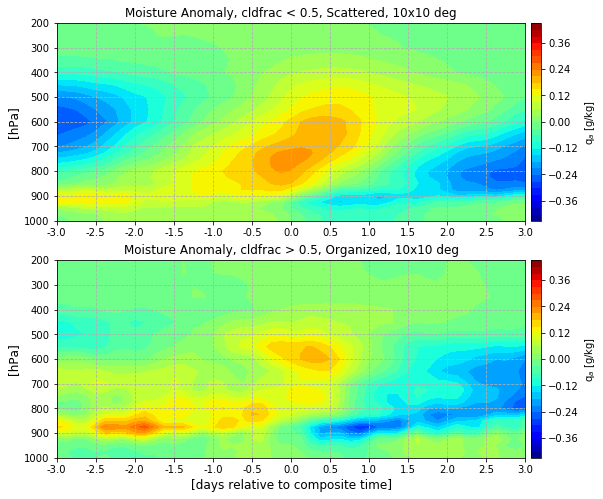

In [262]:
fig = plt.figure(figsize=(10,8))

ax1 = plt.subplot(2,1,1)
cf1 = ax1.contourf(range(49),lev,qverta_orgmean.transpose()*1000,levels=np.linspace(-0.45,0.45,31)
            ,cmap='jet')
cbar1 = plt.colorbar(cf1,pad=0.01);cbar1.set_label('q$_a$ [g/kg]')

ax2 = plt.subplot(2,1,2)
cf2 = ax2.contourf(range(49),lev,qverta_scatmean.transpose()*1000,levels=np.linspace(-0.45,0.45,31)
            ,cmap='jet')
cbar2 = plt.colorbar(cf2,pad=0.01);cbar2.set_label('q$_a$ [g/kg]')

ax1.set_ylabel('[hPa]',fontsize=12);ax1.set_title('Moisture Anomaly, cldfrac < 0.5, Scattered, 10x10 deg')
ax2.set_ylabel('[hPa]',fontsize=12);ax2.set_title('Moisture Anomaly, cldfrac > 0.5, Organized, 10x10 deg')
ax1.set_xticks(np.linspace(0,48,13));ax1.set_xticklabels(np.linspace(-3,3,13))
ax1.set_ylim([1000,200]);ax1.grid(linestyle='--')
ax2.set_ylim([1000,200]);ax2.grid(linestyle='--')
ax2.set_xticks(np.linspace(0,48,13));ax2.set_xticklabels(np.linspace(-3,3,13))
ax2.set_xlabel('[days relative to composite time]',fontsize=12)


In [263]:
#fig.savefig('/w2-data2/willytsai/ISCCP/fig/qanom_compostie_p5mm_10deg.png',dpi=300)

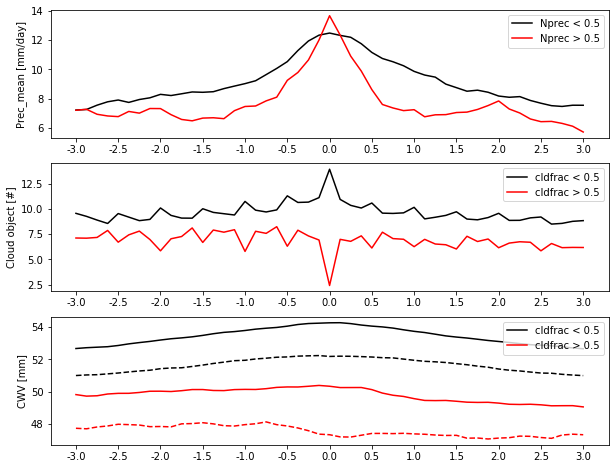

In [264]:
fig = plt.figure(figsize=(10,8))

ax1 = plt.subplot(3,1,1)
ax1.plot(range(49),prec_orgmean*24,'-k');ax1.plot(range(49),prec_scatmean*24,'-r')
ax1.set_xticks(np.linspace(0,48,13));ax1.set_xticklabels(np.linspace(-3,3,13))
ax1.legend(['Nprec < 0.5','Nprec > 0.5'])
ax1.set_ylabel('Prec_mean [mm/day]',fontsize=10)

ax2 = plt.subplot(3,1,2)
ax2.plot(range(49),N_orgmean,'-k');ax2.plot(range(49),N_scatmean,'-r')
ax2.set_xticks(np.linspace(0,48,13));ax2.set_xticklabels(np.linspace(-3,3,13))
ax2.legend(['cldfrac < 0.5','cldfrac > 0.5'])
ax2.set_ylabel('Cloud object [#]',fontsize=10)

ax3 = plt.subplot(3,1,3)
ax3.plot(range(49),cwv_orgmean,'-k');ax3.plot(range(49),cwv_scatmean,'-r')
ax3.plot(range(49),cwvenv_orgmean,'--k');ax3.plot(range(49),cwvenv_scatmean,'--r')
ax3.set_xticks(np.linspace(0,48,13));ax3.set_xticklabels(np.linspace(-3,3,13))
ax3.legend(['cldfrac < 0.5','cldfrac > 0.5'])
ax3.set_ylabel('CWV [mm]',fontsize=10)

plt.show()

In [136]:
#fig.savefig('/w2-data2/willytsai/ISCCP/fig/Allvars_composite_10deg_F1.png',dpi=300)

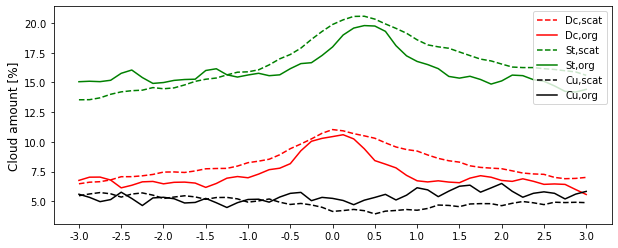

In [265]:
fig = plt.figure(figsize=(10,4))

ax = plt.subplot()
ax.plot(range(49),dc_orgmean,'--r');ax.plot(range(49),dc_scatmean,'-r')
ax.plot(range(49),st_orgmean,'--g');ax.plot(range(49),st_scatmean,'-g')
ax.plot(range(49),cu_orgmean,'--k');ax.plot(range(49),cu_scatmean,'-k')
ax.set_xticks(np.linspace(0,48,13));ax.set_xticklabels(np.linspace(-3,3,13))
ax.legend(['Dc,scat','Dc,org','St,scat','St,org','Cu,scat','Cu,org'])
ax.set_ylabel('Cloud amount [%]',fontsize=12)

plt.show()

In [266]:
#fig.savefig('/w2-data2/willytsai/ISCCP/fig/Allvars_composite_10deg_F2.png',dpi=300)

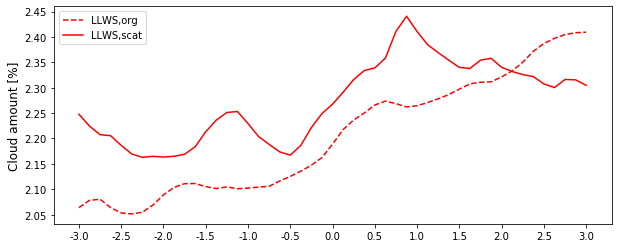

In [267]:
fig = plt.figure(figsize=(10,4))

ax = plt.subplot()
ax.plot(range(49),llwsz_orgmean,'--r');ax.plot(range(49),llwsz_scatmean,'-r')
ax.set_xticks(np.linspace(0,48,13));ax.set_xticklabels(np.linspace(-3,3,13))
ax.legend(['LLWS,org','LLWS,scat'])
ax.set_ylabel('Cloud amount [%]',fontsize=12)

plt.show()

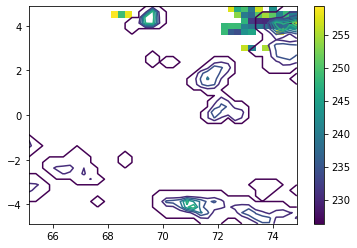

In [35]:
test = bt_sm.sel(time=datetime(2014,7,18)).values.copy()
test[test > 260] = np.nan

cf = plt.pcolor(bt_sm.lon,bt_sm.lat,test)
cbar = plt.colorbar()
plt.contour(prec_sm.lon,prec_sm.lat,prec_sm.sel(time=datetime(2014,7,18)))

3.0


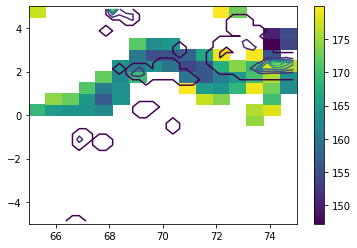

In [36]:
test = olr_sm.sel(time=datetime(2014,5,18)).values.copy()
test[test > 180] = np.nan

cf = plt.pcolor(olr_sm.lon,olr_sm.lat,test)
cbar = plt.colorbar()
plt.contour(prec_sm.lon,prec_sm.lat,prec_sm.sel(time=datetime(2014,5,18)))
cbar.set_clim([1,20])

print(N_prec.sel(time=datetime(2014,5,18)).values)